# ***Import Libarys***

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam


from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet import ResNet101
from tensorflow.keras.applications import ResNet50
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetV2L

import random
import os
import warnings
warnings.filterwarnings('ignore')
print('compelet')

compelet


# ***Data understanding & Visualizatio***

In [82]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_shape = (224,224)
batch_size = 32

# update this to the confirmed correct folder from debug step
train_folder = r'C:\Users\prath\Desktop\Plant_disease\Train'
valid_folder = r'C:\Users\prath\Desktop\Plant_disease\Validation'

assert os.path.exists(train_folder), f"Train folder not found: {train_folder}"
assert os.path.exists(valid_folder), f"Valid folder not found: {valid_folder}"

print("Detected classes:", sorted([d for d in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder,d))])[:10])

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_folder,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_data = train_datagen.flow_from_directory(
    train_folder,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_data = test_datagen.flow_from_directory(
    valid_folder,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Detected classes: ['American Bollworm on Cotton', 'Anthracnose on Cotton', 'Army worm', 'Becterial Blight in Rice', 'Brownspot', 'Common_Rust', 'Cotton Aphid', 'Flag Smut', 'Gray_Leaf_Spot', 'Healthy Maize']
Found 12373 images belonging to 42 classes.
Found 3073 images belonging to 42 classes.
Found 3171 images belonging to 42 classes.


***From previous cell we know that we have 38 class***
> * 56251 images in train data
> * 14044 images in valisation data
> * 17572 images in test data
> * 33 imgeas in test data (the label of test data is the name of image) we will uses them to predict later

***But what are 38 classes ?!***

In [83]:
# show how data store 
images, labels = next(iter(train_data))
print(f'shape of image is : {images[0].shape}')


shape of image is : (224, 224, 3)


In [84]:
# Show all diseases (class names) in the dataset
diseases = os.listdir(train_folder)
print("Diseases in dataset:")
print(diseases)

Diseases in dataset:
['American Bollworm on Cotton', 'Anthracnose on Cotton', 'Army worm', 'bacterial_blight in Cotton', 'Becterial Blight in Rice', 'bollrot on Cotton', 'bollworm on Cotton', 'Brownspot', 'Common_Rust', 'Cotton Aphid', 'cotton mealy bug', 'cotton whitefly', 'Flag Smut', 'Gray_Leaf_Spot', 'Healthy cotton', 'Healthy Maize', 'Healthy Wheat', 'Leaf Curl', 'Leaf smut', 'maize ear rot', 'maize fall armyworm', 'maize stem borer', 'Mosaic sugarcane', 'pink bollworm in cotton', 'red cotton bug', 'RedRot sugarcane', 'RedRust sugarcane', 'Rice Blast', 'Sugarcane Healthy', 'thirps on  cotton', 'Tungro', 'Wheat aphid', 'Wheat black rust', 'Wheat Brown leaf Rust', 'Wheat leaf blight', 'Wheat mite', 'Wheat powdery mildew', 'Wheat scab', 'Wheat Stem fly', 'Wheat___Yellow_Rust', 'Wilt', 'Yellow Rust Sugarcane']


***We notice that we have the same plant in different class such as:***
 > * Tomato___Early_blight
 > * Tomato___Late_blight
 > * Tomato___healthy
 > * ...

***so we need to know what is the different type of plant we have***

In [85]:
# identify uniqe plant in dataset
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
print(f'number of different plants is :{len(plants)}')
print(plants)

number of different plants is :42
['American Bollworm on Cotton', 'Anthracnose on Cotton', 'Army worm', 'bacterial_blight in Cotton', 'Becterial Blight in Rice', 'bollrot on Cotton', 'bollworm on Cotton', 'Brownspot', 'Common_Rust', 'Cotton Aphid', 'cotton mealy bug', 'cotton whitefly', 'Flag Smut', 'Gray_Leaf_Spot', 'Healthy cotton', 'Healthy Maize', 'Healthy Wheat', 'Leaf Curl', 'Leaf smut', 'maize ear rot', 'maize fall armyworm', 'maize stem borer', 'Mosaic sugarcane', 'pink bollworm in cotton', 'red cotton bug', 'RedRot sugarcane', 'RedRust sugarcane', 'Rice Blast', 'Sugarcane Healthy', 'thirps on  cotton', 'Tungro', 'Wheat aphid', 'Wheat black rust', 'Wheat Brown leaf Rust', 'Wheat leaf blight', 'Wheat mite', 'Wheat powdery mildew', 'Wheat scab', 'Wheat Stem fly', 'Wheat', 'Wilt', 'Yellow Rust Sugarcane']


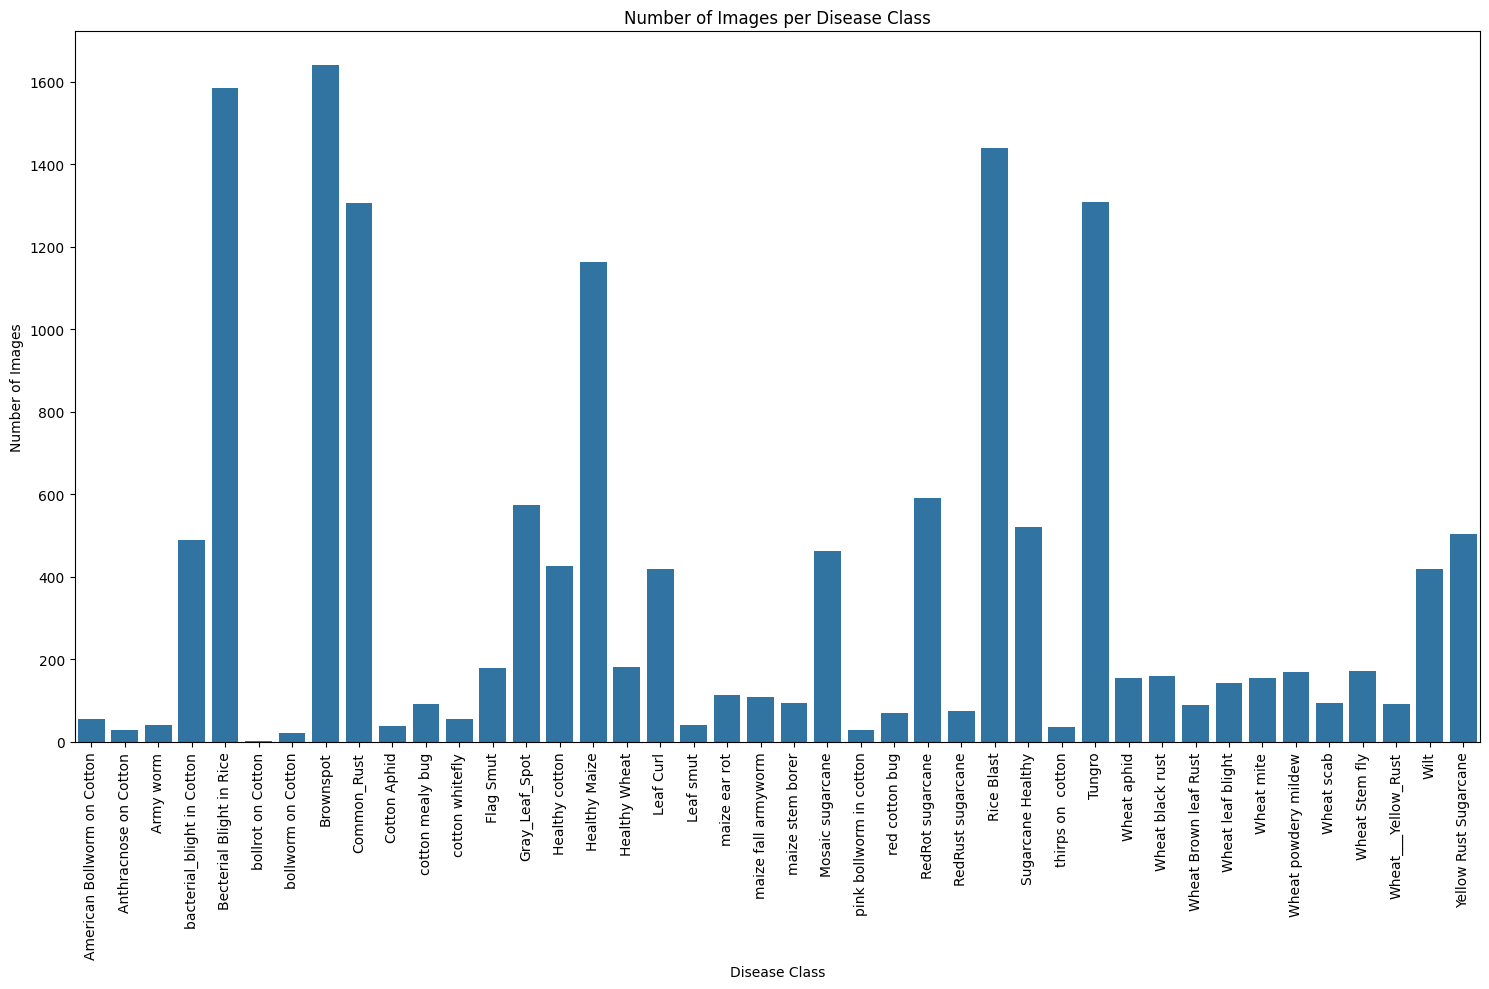

In [86]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create dictionary of class counts
dic = {}
for disease_class in diseases:
    class_path = os.path.join(train_folder, disease_class)
    dic[disease_class] = len(os.listdir(class_path))

# Convert to DataFrame
df = pd.DataFrame(list(dic.items()), columns=["Disease Class", "Number of Images"])

# Optional: sort by number of images
# df = df.sort_values(by="Number of Images", ascending=False)

# Plot
plt.figure(figsize=(15, 10))
sns.barplot(data=df, x='Disease Class', y='Number of Images')
plt.xticks(rotation=90)
plt.title("Number of Images per Disease Class")
plt.tight_layout()
plt.show()


***As we notice that classes are somewhat balanced***

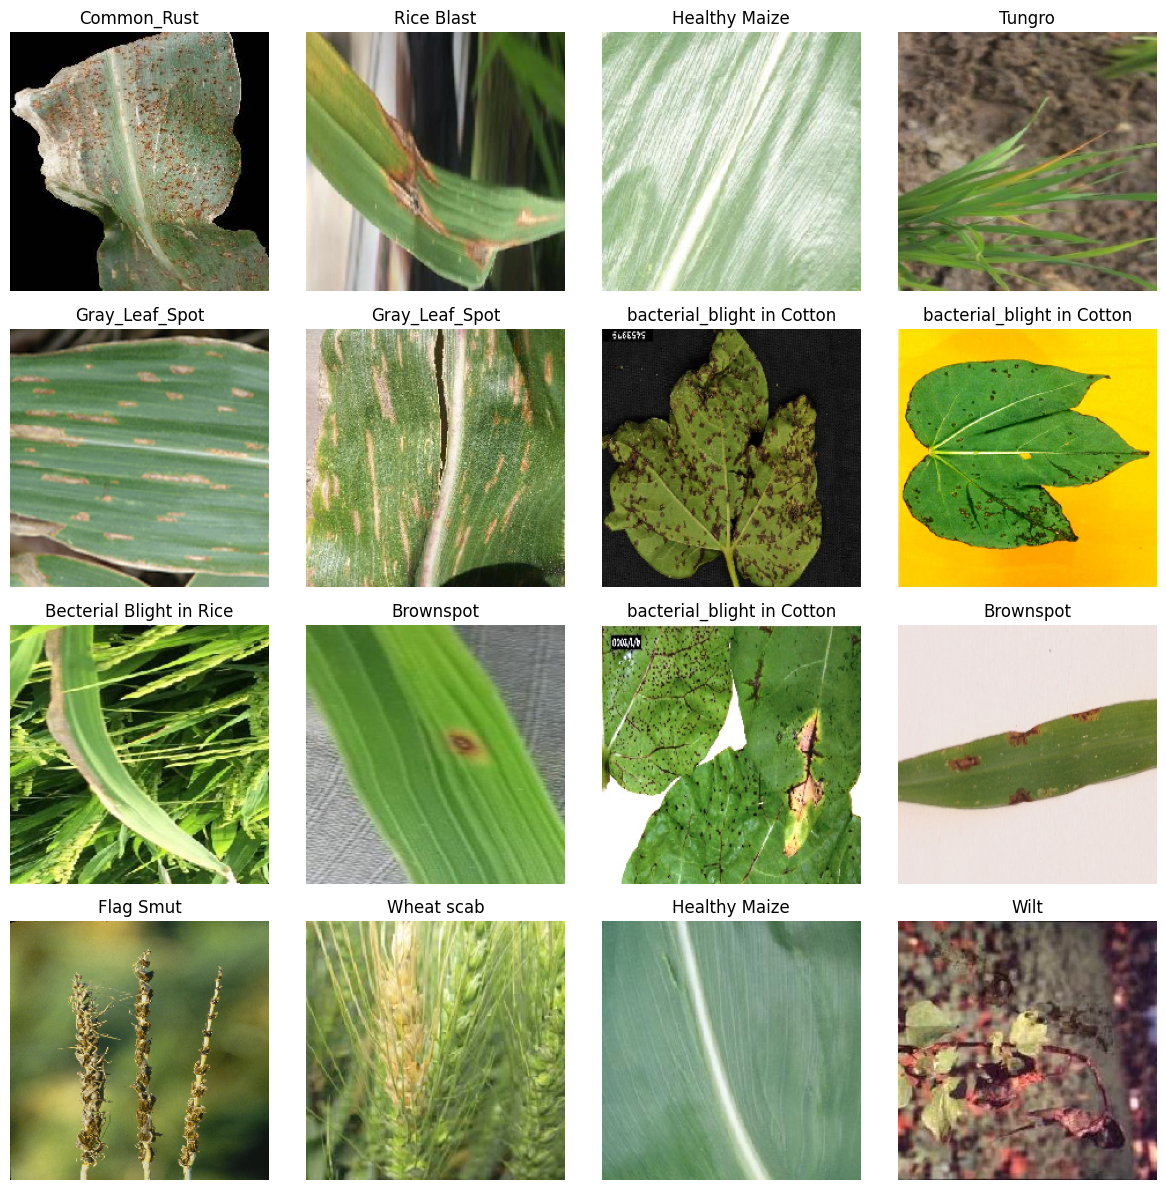

In [87]:
import random
# select a specific batch
images, labels = next(iter(train_data))

# select 16 image by random
indices = random.sample(range(len(images)), 16)
selected_images = images[indices]
selected_labels = labels[indices]

class_names = list(train_data.class_indices.keys())

# plotting
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(selected_images[i])
    plt.title(class_names[np.argmax(selected_labels[i])])  
    plt.axis("off")  

plt.tight_layout()
plt.show()


# ***Modeling***

***Function will be used***

Learning curve function
> * learning curve
> * loss curve

In [88]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    # accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # loss curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


Prediction function
> Compare Truth label (name of image ) with predicted label

In [89]:
def predict_labels_and_display(model_path, test_dir='E:\CSMSS Projects\GPU\DATASET\Dataset of plant diseases\test\test', image_size=(224, 224)):
    # load the best model
    best_model = load_model(model_path)

    true_labels = []
    predicted_labels = []
    images = []

    for filename in os.listdir(test_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')): 
            # load test images
            img_path = os.path.join(test_dir, filename)
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # predict
            prediction = best_model.predict(img_array, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]

            # extract the label (name of image)
            true_label = filename.split('.')[0]

            # get the prediction class
            class_labels = list(train_data.class_indices.keys())
            predicted_label = class_labels[predicted_class]

            true_labels.append(true_label)
            predicted_labels.append(predicted_label)
            images.append(img)

    # randomly select three images
    selected_indices = random.sample(range(len(images)), 3)

    # show selected images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(f'True: {true_labels[idx]}\nPredicted: {predicted_labels[idx]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# ***CNN Model***

In [90]:
# Model Architecture
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'relu',input_shape=(224,224,3), kernel_initializer=GlorotNormal()))
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

# model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(38, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
# inspect generator and model
print("train classes count:", train_data.num_classes)
print("train class_indices:", train_data.class_indices)
print("valid classes count:", valid_data.num_classes)
print("model summary:")
model.summary()
# also last layer units:
print("model output shape:", model.output_shape)
model.summary()

train classes count: 42
train class_indices: {'American Bollworm on Cotton': 0, 'Anthracnose on Cotton': 1, 'Army worm': 2, 'Becterial Blight in Rice': 3, 'Brownspot': 4, 'Common_Rust': 5, 'Cotton Aphid': 6, 'Flag Smut': 7, 'Gray_Leaf_Spot': 8, 'Healthy Maize': 9, 'Healthy Wheat': 10, 'Healthy cotton': 11, 'Leaf Curl': 12, 'Leaf smut': 13, 'Mosaic sugarcane': 14, 'RedRot sugarcane': 15, 'RedRust sugarcane': 16, 'Rice Blast': 17, 'Sugarcane Healthy': 18, 'Tungro': 19, 'Wheat Brown leaf Rust': 20, 'Wheat Stem fly': 21, 'Wheat aphid': 22, 'Wheat black rust': 23, 'Wheat leaf blight': 24, 'Wheat mite': 25, 'Wheat powdery mildew': 26, 'Wheat scab': 27, 'Wheat___Yellow_Rust': 28, 'Wilt': 29, 'Yellow Rust Sugarcane': 30, 'bacterial_blight in Cotton': 31, 'bollrot on Cotton': 32, 'bollworm on Cotton': 33, 'cotton mealy bug': 34, 'cotton whitefly': 35, 'maize ear rot': 36, 'maize fall armyworm': 37, 'maize stem borer': 38, 'pink bollworm in cotton': 39, 'red cotton bug': 40, 'thirps on  cotton':

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,446 (1.39 MB)

 Trainable params: 364,550 (1.39 MB)

 Non-trainable params: 896 (3.50 KB)

model output shape: (None, 38)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,446 (1.39 MB)

 Trainable params: 364,550 (1.39 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
import math
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

num_classes = train_data.num_classes
print("Num classes:", num_classes)

# Create a new Input tensor matching your model's expected input shape.
# Adjust if your model expects different input size / channels.
# Most likely (224,224,3) — replace if your model used other size.
input_shape = (224, 224, 3)

# Build a new functional graph: call the existing model on a fresh Input tensor
inp = Input(shape=input_shape, name='new_input')

# IMPORTANT: call the old model on inp to get its output tensor.
# This will "call" any nested Sequential layers and create a concrete graph.
base_output = model(inp)

# Attach new classification head
new_out = Dense(num_classes, activation='softmax', name='new_logits')(base_output)

# Create the new Model
new_model = Model(inputs=inp, outputs=new_out)

# (Optional) Freeze base-model layers if you want to train only head first
for layer in new_model.layers[:-3]:
    layer.trainable = False

new_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
new_model.summary()

# Callbacks (use local path)
checkpoint_path = r'C:\Users\prath\Desktop\Plant_disease\cnn_model_fixed.keras'
mc = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, mode='max', verbose=1)

# Training steps
steps_per_epoch = math.ceil(train_data.samples / train_data.batch_size)
validation_steps = math.ceil(valid_data.samples / valid_data.batch_size)

history = new_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[mc, es]
)


Num classes: 42


Model: "functional_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ new_input (InputLayer)          │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 38)             │       365,446 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_logits (Dense)              │ (None, 42)             │         1,638 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 367,084 (1.40 MB)

 Trainable params: 366,188 (1.40 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1198 - loss: 3.6964
Epoch 1: val_accuracy improved from None to 0.15880, saving model to C:\Users\prath\Desktop\Plant_disease\cnn_model_fixed.keras
387/387 ━━━━━━━━━━━━━━━━━━━━ 7344s 19s/step - accuracy: 0.1936 - loss: 3.6618 - val_accuracy: 0.1588 - val_loss: 3.6784
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 145s/step - accuracy: 0.2907 - loss: 3.5727  
Epoch 2: val_accuracy improved from 0.15880 to 0.35145, saving model to C:\Users\prath\Desktop\Plant_disease\cnn_model_fixed.keras
387/387 ━━━━━━━━━━━━━━━━━━━━ 55866s 145s/step - accuracy: 0.3094 - loss: 3.5508 - val_accuracy: 0.3514 - val_loss: 3.5141
Epoch 3/10
241/387 ━━━━━━━━━━━━━━━━━━━━ 3:43 2s/step - accuracy: 0.3343 - loss: 3.4992

In [ ]:
#  save model to use later
model.save('ai_crops_model.keras')


In [ ]:
plot_learning_curves(history)

NameError: name 'history' is not defined

In [ ]:
best_model = load_model('ai_crops_model.keras')

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")